In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [ ]:
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='/content/dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True,
                        inferSchema=True)

data_df.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,991638


In [ ]:
malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,53724


In [ ]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features")

#create the pipline
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 88619
Test Dataset Count: 22042
Total Dataset Count: 110661
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6981,[0,1,2,3,18...|(6981,[0,1,2,3,18...|
|https://semana-da...|    1|[https, semana, d...|(6981,[0,3,6,18,2...|(6981,[0,3,6,18,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6981,[0,6,834],[...|(6981,[0,6,834],[...|
|http://my-softban...|    1|[http, my, softba...|(6981,[0,1,29,160...|(6981,[0,1,29,160...|
|http://www.my-sof...|    1|[http, www, my, s...|(6981,[0,1,4,29,1...|(6981,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45609
1,0,43010


In [ ]:
#==============[ LOGISTIC REGRESSION ]=========================
r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0


# Build logistic regresssion model
for i in range(1,6):

    dataset = pipelineFit.transform(sampled)

    #randomly split the dataset to traning and testing 80%, 20% respectively
    #(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
    #print("\n")
    #trainingData.groupby('label').count().toPandas()

    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = lrModel.transform(testData)
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


True Positives: 10731
True Negative: 10713
False Positive: 1
False Negative: 597
Total: 22042

Accuracy: 97.287
F-Score: 97.2892111
Recall: 94.7299
Precision: 99.9907


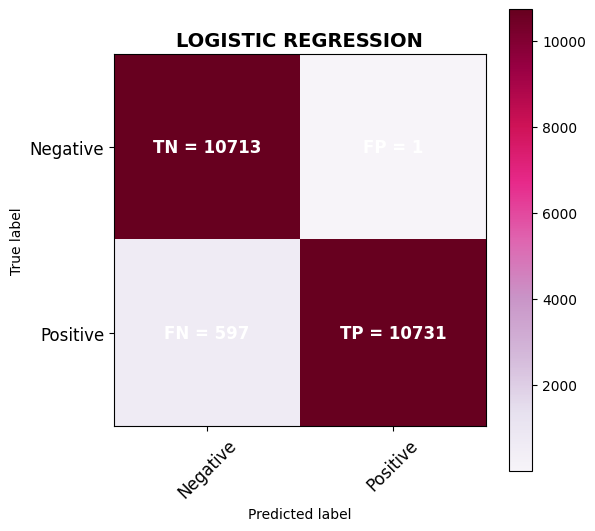

areaUnderROC: 0.9955959621074598


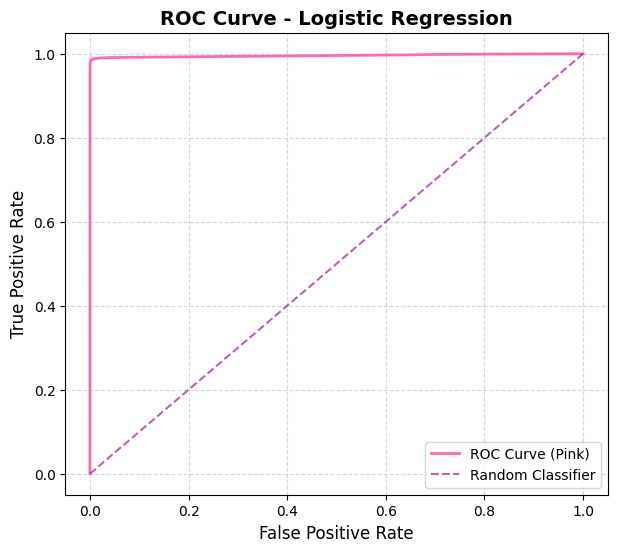

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9988997794...|0.0011832763...|
|0.9981345701...|0.0024963868...|
|0.9971104290...|0.0043318456...|
|0.9964368214...|0.0082101447...|
|0.9957326076...|0.0093837290...|
|0.9950483284...|0.0106860906...|
|0.9941705808...|0.0119867491...|
|0.9934575482...|0.0131558885...|
|0.9927214727...|0.0144101001...|
|0.9919827942...|0.0156627292...|
+---------------+---------------+
only showing top 10 rows



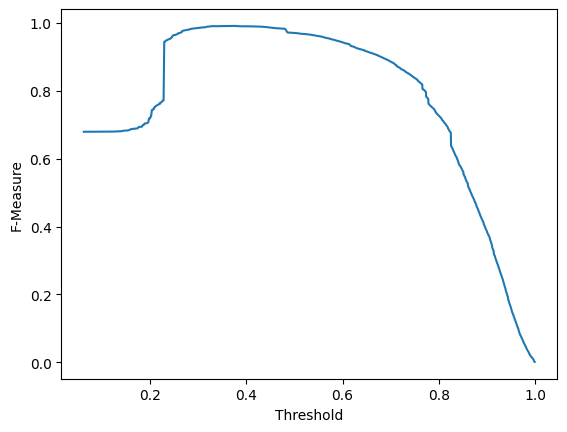

+-------------------------------------+-----+----------+
|                                  url|label|prediction|
+-------------------------------------+-----+----------+
|              nike-airmax-pas-cher.fr|    0|       0.0|
|                 cialis-20mg-buy.info|    0|       0.0|
|               buy-viagra-100mg.store|    0|       0.0|
|         michael-kors-outletonline.us|    0|       0.0|
|cialis-buy-withoutprescription.online|    0|       0.0|
|    cheapestprice-generic-levitra.com|    0|       0.0|
|                    biwako-hall.or.jp|    0|       0.0|
|                flagyl-buy-500mg.mobi|    0|       0.0|
|                         audit.gov.ru|    0|       0.0|
|     genericcialis-cheapest-price.net|    0|       0.0|
+-------------------------------------+-----+----------+
only showing top 10 rows



In [ ]:
#===========================ploting

#plt.clf()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ================= Confusion Matrix ==================
lr_predictions = lrModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap="PuRd")  # Purple-Pink colormap
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION', fontsize=14, fontweight="bold")
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, fontsize=12)
plt.yticks(tick_marks, classNames, fontsize=12)

# TN, FP, FN, TP labels
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]),
                 ha='center', va='center',
                 color="white", fontsize=12, fontweight="bold")

plt.colorbar()
plt.show()

# ================= ROC Curve ==================
trainingSummary = lrModel.summary
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

roc = trainingSummary.roc.toPandas()
plt.figure(figsize=(7,6))
plt.plot(roc['FPR'], roc['TPR'], color="#FF69B4", linewidth=2, label="ROC Curve (Pink)")  # Hot Pink
plt.plot([0,1],[0,1], linestyle="--", color="purple", alpha=0.6, label="Random Classifier")  # Purple dashed line
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)

#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

In [ ]:
#==============[ Cross Validation for Logistic Regression ]=====================
# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

# Define the evaluator



#=============================================================



In [ ]:
evaluator = BinaryClassificationEvaluator()

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)



In [ ]:
# Run cross validations
cvModel = cv.fit(trainingData)


In [ ]:
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

In [ ]:

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#================================================================
df = predictions.select('prediction', 'label')

predictionAndLabels=df.rdd
metrics = MulticlassMetrics(predictionAndLabels)

Test: Area Under ROC: 0.995691033281603


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:



tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)


print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))



True Positives: 11021
True Negative: 10711
False Positive: 3
False Negative: 307
Total: 22042
F-Score: 98.6130991

Accuracy: 98.5936
Recall: 97.2899
Precision: 99.9728


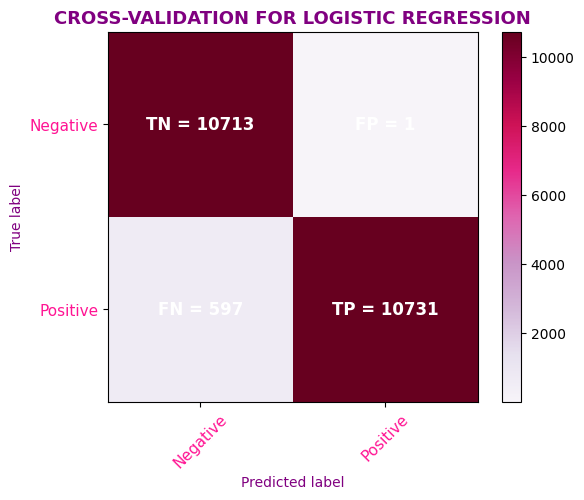

In [ ]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap="PuRd")  # Purple-Pink colormap
classNames = ['Negative','Positive']
plt.title('CROSS-VALIDATION FOR LOGISTIC REGRESSION', color="purple", fontsize=13, fontweight="bold")
plt.ylabel('True label', color="purple")
plt.xlabel('Predicted label', color="purple")
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, color="deeppink", fontsize=11)
plt.yticks(tick_marks, classNames, color="deeppink", fontsize=11)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]),
                 ha='center', va='center', color="white", fontsize=12, fontweight="bold")

plt.colorbar()
plt.show()


Predictions DataFrame Schema:
root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- Words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawfeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)


First 10 rows of predictions DataFrame:
+-----------------------------+-----+----------------------------------+-------------------------+-----------------------------------------------------+-----------------------------------------+-----------------------------------------+----------+
|url                          |label|Words                             |rawfeatures              |features                                             |rawPrediction                            |probability                              |prediction|
+-----------------------------+-----+-------------------

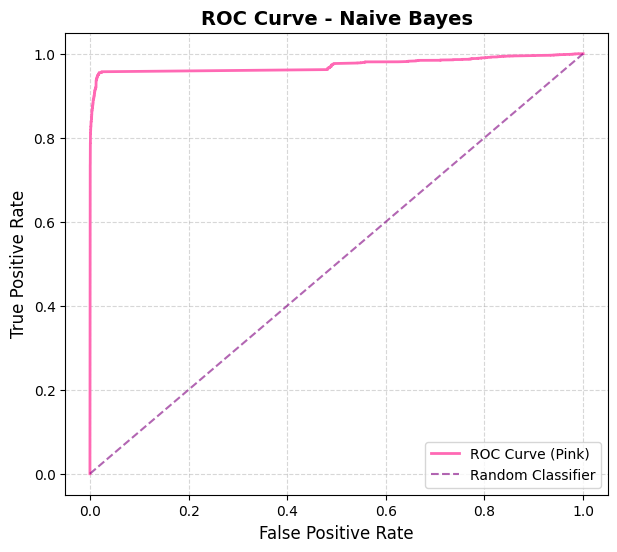

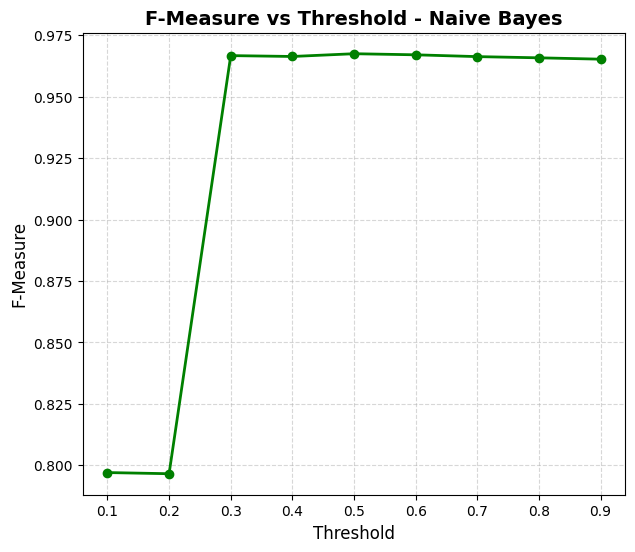

+--------------------------------------+-----+----------+
|                                   url|label|prediction|
+--------------------------------------+-----+----------+
|                      hs-regensburg.de|    0|       0.0|
|http://people.santanderconsumer.it/faq|    1|       0.0|
|                             jfcom.mil|    0|       0.0|
|                        yeezy-shoes.ca|    0|       0.0|
|                              earth.li|    0|       0.0|
|        http://xn--b1axgdf5j.xn--j1amh|    1|       0.0|
|                       handmade-spa.ru|    0|       0.0|
|                       schaeffer-ag.de|    0|       0.0|
|                       dk-kogebogen.dk|    0|       0.0|
|                        feps-europe.eu|    0|       0.0|
+--------------------------------------+-----+----------+
only showing top 10 rows



In [ ]:
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial",)

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)

# Display schema and first few rows of predictions dataframe and probability column to diagnose the error
print("Predictions DataFrame Schema:")
predictions.printSchema()
print("\nFirst 10 rows of predictions DataFrame:")
predictions.show(10, truncate=False)
print("\nFirst 10 rows of the 'probability' column:")
predictions.select("probability").show(10, truncate=False)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#===========================
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


# ===========================
# ROC Curve (Styled like your example)
# ===========================
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc
import pandas as pd # Import pandas here

# Convert the probability column to an array and then to a pandas DataFrame
# This assumes the probability column is a vector with probabilities for each class
# For binary classification, the second element (index 1) is the probability of the positive class
try:
    predictions_with_prob_array = predictions.withColumn("probability_array", vector_to_array("probability"))
    y_score_df = predictions_with_prob_array.select("probability_array").toPandas()
    y_score = y_score_df['probability_array'].apply(lambda x: x[1] if len(x) > 1 else 0).tolist() # Access the second element and handle potential empty/short arrays

    # Collect true labels
    y_true = predictions_with_prob_array.select("label").toPandas()['label'].tolist()

    # Compute ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color="#FF69B4", linewidth=2, label="ROC Curve (Pink)")  # Hot Pink
    plt.plot([0,1],[0,1], linestyle="--", color="purple", alpha=0.6, label="Random Classifier")  # Purple
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve - Naive Bayes", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

except Exception as e:
    print(f"Error plotting ROC curve: {e}")


# ===========================
# F-measure vs Threshold
# ===========================
from pyspark.sql.functions import col

# Calculate precision, recall, f1 for different thresholds manually
thresholds = [i/10.0 for i in range(1,10)]
f_measures = []

for t in thresholds:
    # Ensure 'predictions_with_prob_array' is used here as it contains the 'probability_array'
    if 'predictions_with_prob_array' in locals():
        preds = predictions_with_prob_array.withColumn("custom_prediction", (col("probability_array")[1] > t).cast("int"))
        tp = preds.filter((col("custom_prediction")==1) & (col("label")==1)).count()
        fp = preds.filter((col("custom_prediction")==1) & (col("label")==0)).count()
        fn = preds.filter((col("custom_prediction")==0) & (col("label")==1)).count()

        precision = tp / (tp+fp) if (tp+fp) > 0 else 0
        recall = tp / (tp+fn) if (tp+fn) > 0 else 0
        f1 = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0
        f_measures.append(f1)
    else:
        print("Error: 'predictions_with_prob_array' not found. ROC curve plotting likely failed.")
        break # Exit the loop if ROC plotting failed

if f_measures: # Only plot if f_measures were calculated
    plt.figure(figsize=(7,6))
    plt.plot(thresholds, f_measures, marker='o', color="green", linewidth=2)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("F-Measure", fontsize=12)
    plt.title("F-Measure vs Threshold - Naive Bayes", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# ===========================
# Top Predictions Display
# ===========================
predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)

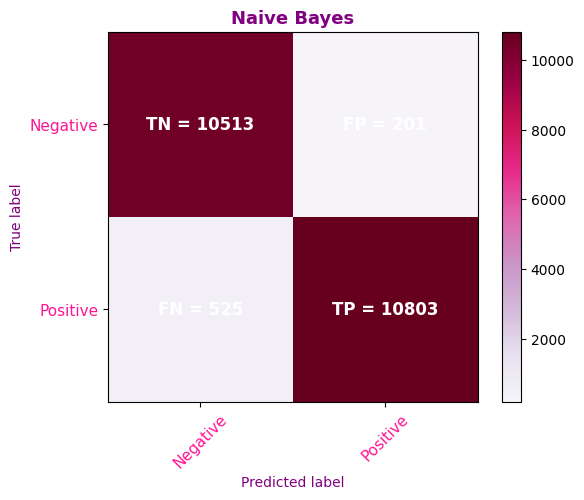

In [ ]:
#plt.clf()
nb_predictions = model.transform(testData)

y_actu = nb_predictions.select("label").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap="PuRd")  # Purple-Pink colormap
classNames = ['Negative','Positive']
plt.title('Naive Bayes', color="purple", fontsize=13, fontweight="bold")
plt.ylabel('True label', color="purple")
plt.xlabel('Predicted label', color="purple")
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, color="deeppink", fontsize=11)
plt.yticks(tick_marks, classNames, color="deeppink", fontsize=11)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]),
                 ha='center', va='center', color="white", fontsize=12, fontweight="bold")

plt.colorbar()
plt.show()


In [ ]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):


    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    #predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)


    #================================================================
    df = predictions.select('prediction', 'label')
    predictionAndLabels=df.rdd

    metrics = MulticlassMetrics(predictionAndLabels)



    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))

    print("\nAccuracy: %g" %(a*100))
    print("Recall: %g" %(r*100))
    print("Precision: %g" %(p*100))





Root Mean Squared Error (RMSE) on test data = 0.129035


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


True Positives: 10969
True Negative: 10706
False Positive: 8
False Negative: 359
Total: 22042
F-Score: 98.3546291

Accuracy: 98.335
Recall: 96.8309
Precision: 99.9271


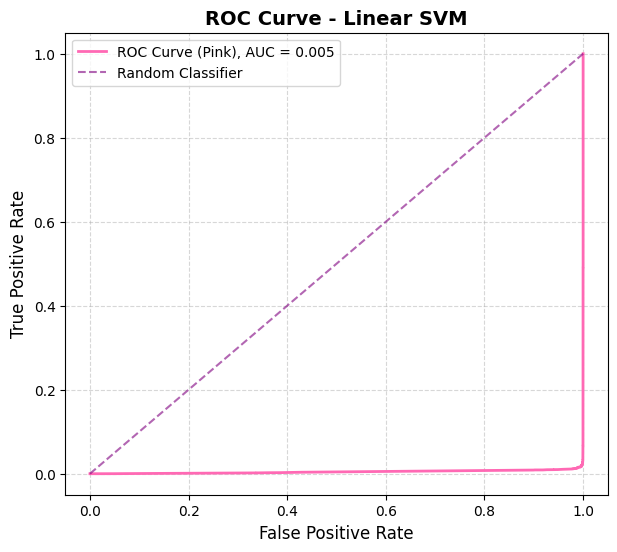

Area Under ROC: 0.005
Accuracy: 98.32%


In [56]:
# ===========================
# ROC Curve + AUC + Accuracy for LinearSVC
# ===========================
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc, accuracy_score

# Convert rawPrediction (margin scores) into array
predictions_with_margin = predictions.withColumn("rawPrediction_array", vector_to_array("rawPrediction"))

# Convert to Pandas for ROC
y_score = predictions_with_margin.select("rawPrediction_array").toPandas()['rawPrediction_array'].apply(lambda x: float(x[0])).tolist()
y_true = predictions_with_margin.select("label").toPandas()['label'].tolist()
y_pred = predictions_with_margin.select("prediction").toPandas()['prediction'].tolist()

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Compute Accuracy
acc = accuracy_score(y_true, y_pred)

# ===========================
# Plot ROC Curve
# ===========================
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="#FF69B4", linewidth=2, label="ROC Curve (Pink), AUC = %0.3f" % roc_auc)
plt.plot([0,1],[0,1], linestyle="--", color="purple", alpha=0.6, label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Linear SVM", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ===========================
# Print Evaluation Metrics
# ===========================
print("Area Under ROC: %0.3f" % roc_auc)
print("Accuracy: %0.2f%%" % (acc*100))


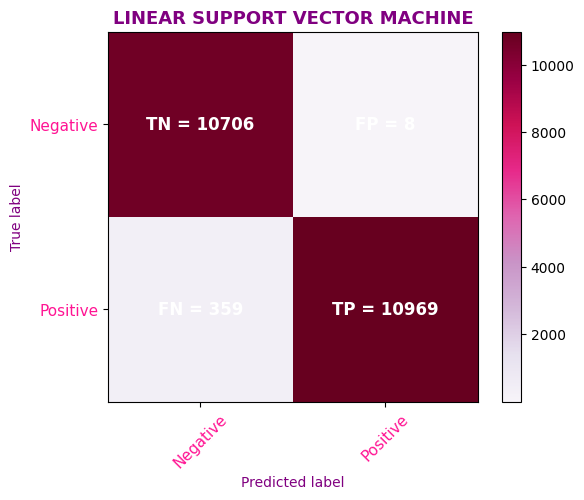

In [ ]:
#=============================================================

#==================[ Confusing Matrix Calculation and Plotting ]
lsvm_predictions = lsvcModel.transform(testData)

y_actu = lsvm_predictions.select("label").toPandas()
y_pred = lsvm_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap="PuRd")  # Purple-Pink colormap
classNames = ['Negative','Positive']
plt.title('LINEAR SUPPORT VECTOR MACHINE', color="purple", fontsize=13, fontweight="bold")
plt.ylabel('True label', color="purple")
plt.xlabel('Predicted label', color="purple")
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, color="deeppink", fontsize=11)
plt.yticks(tick_marks, classNames, color="deeppink", fontsize=11)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]),
                 ha='center', va='center', color="white", fontsize=12, fontweight="bold")

plt.colorbar()
plt.show()


In [ ]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

for i in range(1, 2):

    # instantiate the base classifier.
    #lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
    lr = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0, tol=1E-6, fitIntercept=True )

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(trainingData)

    # score the model on test data.
    predictions = ovrModel.transform(testData)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    print("\nAccuracy on Test Data = %g" % (accuracy*100))

    #evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
    #accuracy = evaluator.evaluate(predictions)
    #print("Accuracy = %g" % (accuracy*100))

    #evaluatorf1 = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="f1")
    #f1 = evaluatorf1.evaluate(predictions)
    #print("f1 = %g" % (f1*100))

    #================================================================
    df = predictions.select('prediction', 'label')

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))
    print("Recal: %g" %(r*100))
    print("Precision: %g" %(p*100))
    print("Accuracy: %g" %(a*100))

Test Error = 0.00775792

Accuracy on Test Data = 99.2242
True Positives: 11168
True Negative: 10703
False Positive: 11
False Negative: 160
Total: 22042
F-Score: 99.2402361
Recal: 98.5876
Precision: 99.9016
Accuracy: 99.2242


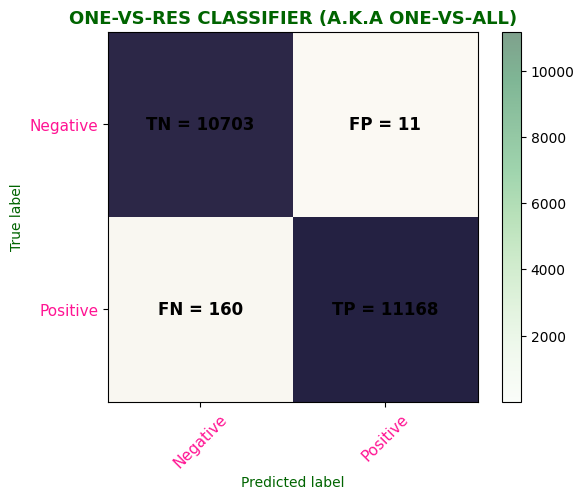

In [ ]:
#=============================================================

ovr_predictions = ovrModel.transform(testData)

y_actu = ovr_predictions.select("label").toPandas()
y_pred = ovr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap="RdPu")  # Light pink tones
plt.imshow(cm, interpolation='nearest', cmap="Greens", alpha=0.5)  # Overlay with light green
classNames = ['Negative','Positive']
plt.title('ONE-VS-RES CLASSIFIER (A.K.A ONE-VS-ALL)', color="darkgreen", fontsize=13, fontweight="bold")
plt.ylabel('True label', color="darkgreen")
plt.xlabel('Predicted label', color="darkgreen")
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45, color="deeppink", fontsize=11)
plt.yticks(tick_marks, classNames, color="deeppink", fontsize=11)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]),
                 ha='center', va='center', color="black", fontsize=12, fontweight="bold")

plt.colorbar()
plt.show()



In [ ]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.

df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=3, minDF=2.0)

#


#rescaledData = idfModel.transform(cv)

model = cv.fit(df)
result = model.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")

idfModel = idf.fit(result)

rescaledData = idfModel.transform(result)





result.show(truncate=False)

rescaledData.show(truncate=False)

+---+---------------+-------------------------+
|id |words          |rawFeatures              |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+

+---+---------------+-------------------------+-------------------------+
|id |words          |rawFeatures              |features                 |
+---+---------------+-------------------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
+---+---------------+-------------------------+-------------------------+



In [ ]:
dataset.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6981,[0,1,2,3,18...|(6981,[0,1,2,3,18...|
|https://semana-da...|    1|[https, semana, d...|(6981,[0,3,6,18,2...|(6981,[0,3,6,18,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6981,[0,6,834],[...|(6981,[0,6,834],[...|
|http://my-softban...|    1|[http, my, softba...|(6981,[0,1,29,160...|(6981,[0,1,29,160...|
|http://www.my-sof...|    1|[http, www, my, s...|(6981,[0,1,4,29,1...|(6981,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# ==========================================
# CNN Model
# ==========================================
cnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining CNN Model...")
cnn_history = cnn_model.fit(
    X_train_padded, y_train,
    epochs=3,                 # 🔹 3 epochs
    batch_size=300,           # 🔹 300 samples per batch
    validation_data=(X_test_padded, y_test),
    verbose=1
)

# ==========================================
# RNN (LSTM) Model
# ==========================================
rnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining RNN (LSTM) Model...")
rnn_history = rnn_model.fit(
    X_train_padded, y_train,
    epochs=3,                 # 🔹 3 epochs
    batch_size=300,           # 🔹 300 samples per batch
    validation_data=(X_test_padded, y_test),
    verbose=1
)

# ==========================================
# Evaluation
# ==========================================
cnn_acc = cnn_model.evaluate(X_test_padded, y_test, verbose=0)[1]
rnn_acc = rnn_model.evaluate(X_test_padded, y_test, verbose=0)[1]

print(f"\n✅ CNN Test Accuracy: {cnn_acc:.4f}")
print(f"✅ RNN (LSTM) Test Accuracy: {rnn_acc:.4f}")



Training CNN Model...
Epoch 1/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.9685 - loss: 0.1454 - val_accuracy: 0.9939 - val_loss: 0.0316
Epoch 2/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 277ms/step - accuracy: 0.9938 - loss: 0.0317 - val_accuracy: 0.9939 - val_loss: 0.0345
Epoch 3/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 140s 273ms/step - accuracy: 0.9945 - loss: 0.0296 - val_accuracy: 0.9938 - val_loss: 0.0322

Training RNN (LSTM) Model...
Epoch 1/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 149s 497ms/step - accuracy: 0.5110 - loss: 0.6931 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 2/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 209s 521ms/step - accuracy: 0.5096 - loss: 0.6930 - val_accuracy: 0.5134 - val_loss: 0.6931
Epoch 3/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 154s 518ms/step - accuracy: 0.5128 - loss: 0.6929 - val_accuracy: 0.5134 - val_loss: 0.6929

✅ CNN Test Accuracy: 0.9938
✅ RNN (LSTM) Test Accuracy: 0.5134


692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


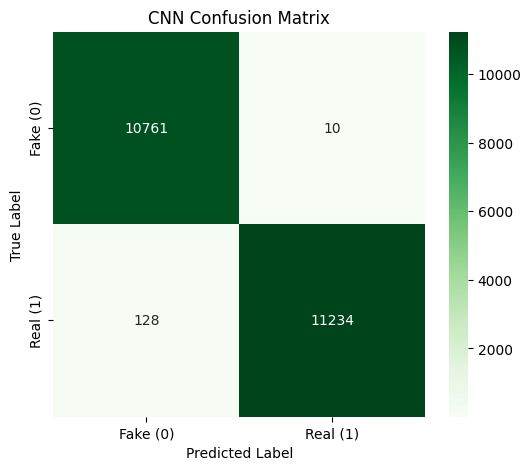


CNN Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.99      1.00      0.99     10771
    Real (1)       1.00      0.99      0.99     11362

    accuracy                           0.99     22133
   macro avg       0.99      0.99      0.99     22133
weighted avg       0.99      0.99      0.99     22133

692/692 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step


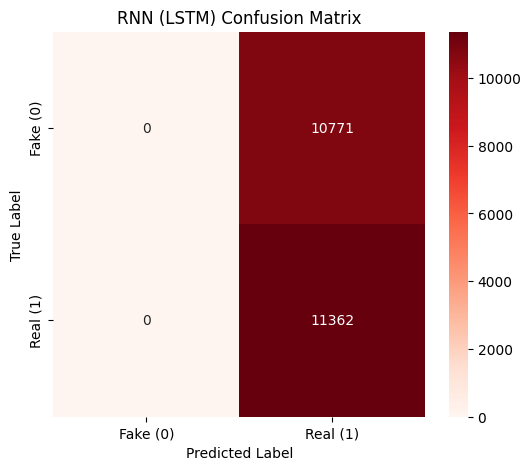


RNN (LSTM) Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.00      0.00      0.00     10771
    Real (1)       0.51      1.00      0.68     11362

    accuracy                           0.51     22133
   macro avg       0.26      0.50      0.34     22133
weighted avg       0.26      0.51      0.35     22133



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# CNN Confusion Matrix
# ==============================
y_pred_cnn = (cnn_model.predict(X_test_padded) > 0.5).astype("int32")

cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap="Greens", xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=["Fake (0)", "Real (1)"]))


# ==============================
# RNN Confusion Matrix
# ==============================
y_pred_rnn = (rnn_model.predict(X_test_padded) > 0.5).astype("int32")

cm_rnn = confusion_matrix(y_test, y_pred_rnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap="Reds", xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.title("RNN (LSTM) Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nRNN (LSTM) Classification Report:")
print(classification_report(y_test, y_pred_rnn, target_names=["Fake (0)", "Real (1)"]))


692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


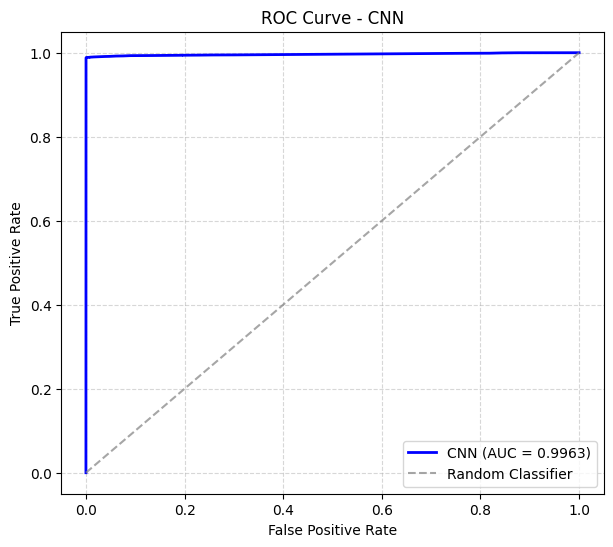

692/692 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step


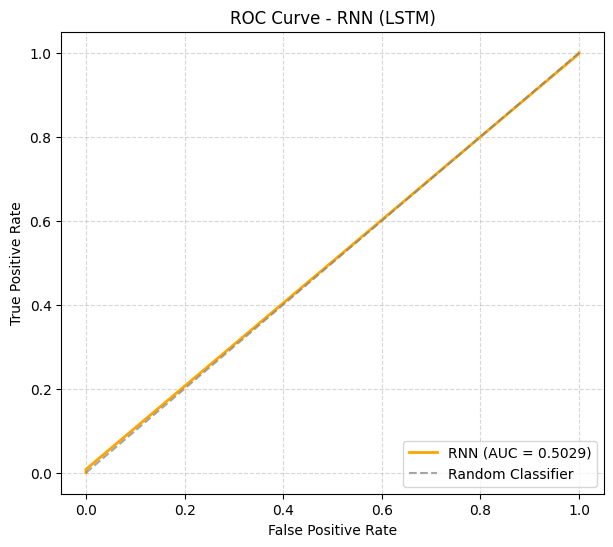

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

# ==============================
# CNN ROC Curve
# ==============================
y_prob_cnn = cnn_model.predict(X_test_padded).ravel()
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)
auc_cnn = roc_auc_score(y_test, y_prob_cnn)

plt.figure(figsize=(7,6))
plt.plot(fpr_cnn, tpr_cnn, color="blue", linewidth=2, label=f"CNN (AUC = {auc_cnn:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray", alpha=0.7, label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ==============================
# RNN ROC Curve
# ==============================
y_prob_rnn = rnn_model.predict(X_test_padded).ravel()
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_prob_rnn)
auc_rnn = roc_auc_score(y_test, y_prob_rnn)

plt.figure(figsize=(7,6))
plt.plot(fpr_rnn, tpr_rnn, color="orange", linewidth=2, label=f"RNN (AUC = {auc_rnn:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray", alpha=0.7, label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNN (LSTM)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
